Step 1: 数据已加载并转换时间格式。
Step 2: 已成功重采样为 M15 和 H1 时间框架。
Step 3 & 4: 已计算布林带和 MACD rsi。

M15 Analysis: {'Current Price': 2860.135, 'Bollinger Upper': 2863.8244187413165, 'Bollinger Lower': 2858.005781258683, 'Bollinger Width': 5.818637482633676, 'MACD': -1.4616709738161262, 'MACD Histogram': 0.18517980819609603, 'RSI': 40.70021881838053, 'ATVV': 5120.1, 'Trend': 'Bullish'}
H1 Analysis: {'Current Price': 2860.135, 'Bollinger Upper': 2876.265540518347, 'Bollinger Lower': 2854.307659481654, 'Bollinger Width': 21.957881036692925, 'MACD': 0.14558584033602529, 'MACD Histogram': -1.1039904675072343, 'RSI': 46.25688788289217, 'ATVV': 37750.8, 'Trend': 'Bearish'}


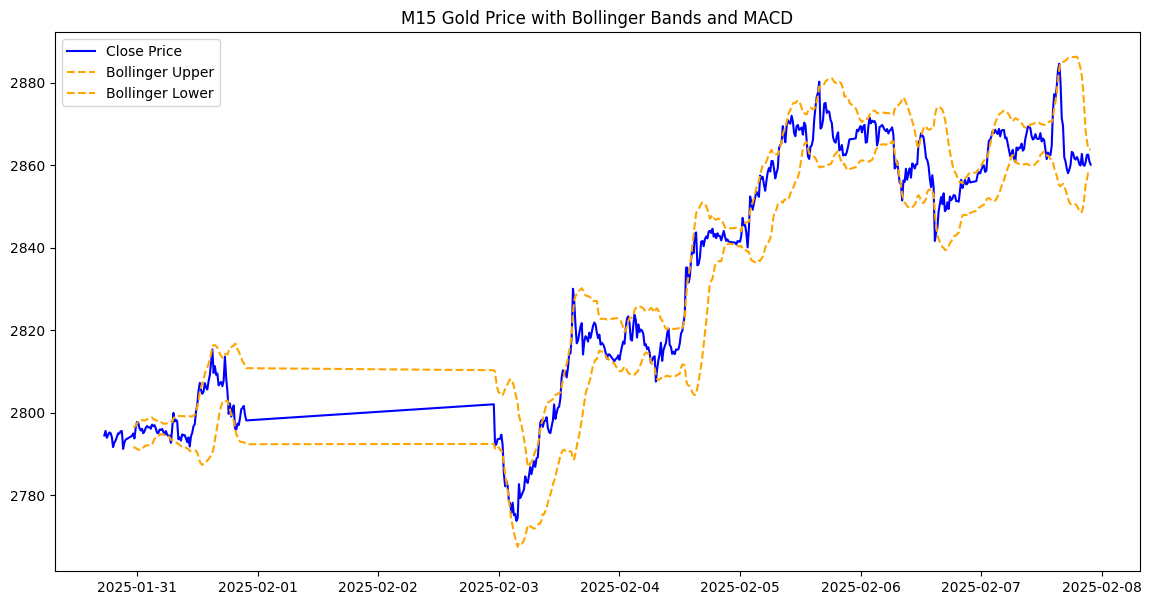

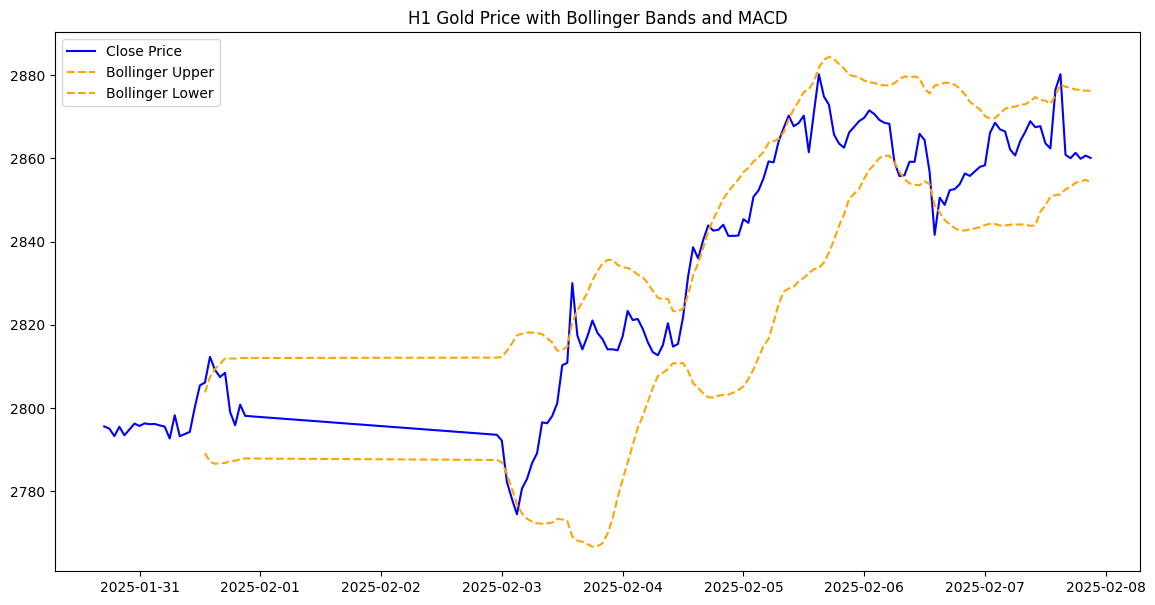

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Step 1: 读取并准备数据
def load_and_prepare_data(minute_file_path, day_file_path):
    """
    读取分钟数据和日线数据，转换时间格式并返回两个 DataFrame。
    """
    minute_data = pd.read_csv(minute_file_path)
    minute_data['time'] = pd.to_datetime(minute_data['time'], unit='s')
    minute_data.set_index('time', inplace=True)
    
    day_data = pd.read_csv(day_file_path)
    day_data['time'] = pd.to_datetime(day_data['time'])
    return minute_data, day_data

minute_data, day_data = load_and_prepare_data('data/130209min.csv', 'data/240209.csv')

print("Step 1: 数据已加载并转换时间格式。")

# Step 2: 重采样为 M15 和 H1 时间框架
m15_data = minute_data.resample('15T').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'ATVV': 'sum'  # 聚合 ATVV
}).dropna()
h1_data = minute_data.resample('1H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'ATVV':'sum'
}).dropna()

print("Step 2: 已成功重采样为 M15 和 H1 时间框架。")
m15_data.head()
# Step 3: 计算布林带
def calculate_bollinger_bands(data, column='close', window=20):
    data['SMA_20'] = data[column].rolling(window=window).mean()
    data['std_20'] = data[column].rolling(window=window).std()
    data['bollinger_upper'] = data['SMA_20'] + (2 * data['std_20'])
    data['bollinger_lower'] = data['SMA_20'] - (2 * data['std_20'])
    data['bollinger_width'] = data['bollinger_upper'] - data['bollinger_lower']
    return data

# Step 4: 计算 MACD 和 rsi
def calculate_macd(data, column='close', short_span=12, long_span=26, signal_span=9):
    data['EMA_12'] = data[column].ewm(span=short_span, adjust=False).mean()
    data['EMA_26'] = data[column].ewm(span=long_span, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal'] = data['MACD'].ewm(span=signal_span, adjust=False).mean()
    data['MACD_histogram'] = data['MACD'] - data['Signal']
    return data
def calculate_rsi(data, column='close', window=14):
    delta = data[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data


# 计算布林带和 MACD
m15_data = calculate_bollinger_bands(m15_data)
m15_data = calculate_macd(m15_data)
m15_data = calculate_rsi(m15_data)
h1_data = calculate_bollinger_bands(h1_data)
h1_data = calculate_macd(h1_data)
h1_data = calculate_rsi(h1_data)
print("Step 3 & 4: 已计算布林带和 MACD rsi。")

# Step 4: 更新市场分析函数，包含 RSI 和 ATVV
def analyze_market(data):
    """
    分析市场状态，包含 Bollinger Bands、MACD、RSI 和 ATVV。
    """
    latest = data.iloc[-1]
    result = {
        "Current Price": latest['close'],
        "Bollinger Upper": latest['bollinger_upper'],
        "Bollinger Lower": latest['bollinger_lower'],
        "Bollinger Width": latest['bollinger_width'],
        "MACD": latest['MACD'],
        "MACD Histogram": latest['MACD_histogram'],
        "RSI": latest['RSI'],
        "ATVV": latest['ATVV'],
        "Trend": "Bullish" if latest['MACD'] > latest['Signal'] else "Bearish"
    }
    return result

m15_analysis = analyze_market(m15_data)
h1_analysis = analyze_market(h1_data)
print("\nM15 Analysis:", m15_analysis)
print("H1 Analysis:", h1_analysis)

# Step 6: 可视化布林带和价格走势
def plot_bollinger_bands(data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['close'], label='Close Price', color='blue')
    plt.plot(data.index, data['bollinger_upper'], label='Bollinger Upper', linestyle='--', color='orange')
    plt.plot(data.index, data['bollinger_lower'], label='Bollinger Lower', linestyle='--', color='orange')
    plt.title(title)
    plt.legend()
    plt.show()

plot_bollinger_bands(m15_data, "M15 Gold Price with Bollinger Bands and MACD")
plot_bollinger_bands(h1_data, "H1 Gold Price with Bollinger Bands and MACD")


In [100]:
def load_data(path:list,type='m'):
    r_data = []
    for file in path:
        data = pd.read_csv(file)
        if type == 'm':
            data['time'] = pd.to_datetime(data['time'], unit='s')
            #data.set_index('time',inplace=True)
            r_data.append(data)
        elif type == 'd':
            data['time'] = pd.to_datetime(data['time'],unit='s')
            r_data.append(data)
    return r_data

In [92]:


def RSI_Wilder(data, period=14):
    """
    使用 Wilder’s Smoothing Method (RMA) 计算 RSI。

    参数：
    - data: 必须包含 'close' 列的 Pandas DataFrame
    - period: 默认 14

    返回：
    - 在原 DataFrame 中添加一列 'RSI', 并返回
    """
    # 1) 计算收盘价变化 delta
    delta = data['close'].diff(1)
    
    # 2) 计算涨幅（gain）和跌幅（loss）
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # 3) 使用前 period 条数据，计算初始均值 (简单平均)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    
    # 4) 创建数组来存储 Wilder’s 平滑结果 (RMA)
    rma_gain = np.zeros_like(gain)
    rma_loss = np.zeros_like(loss)
    
    rma_gain[:period] = np.nan
    rma_loss[:period] = np.nan

    # 5) 找到第一个非 NaN 的索引，作为初始值
    first_valid = period
    
    if len(data) >= period:
        rma_gain[first_valid] = avg_gain.iloc[first_valid]
        rma_loss[first_valid] = avg_loss.iloc[first_valid]
        
        # 6) 从第 (period+1) 行开始，Wilder’s 平滑递推
        for i in range(first_valid + 1, len(data)):
            rma_gain[i] = (rma_gain[i-1] * (period - 1) + gain.iloc[i]) / period
            rma_loss[i] = (rma_loss[i-1] * (period - 1) + loss.iloc[i]) / period
    
    # 7) 计算 RSI
    RS = rma_gain / rma_loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    # 将 RSI 值写回 DataFrame
    data['RSI_Wilder'] = RSI
    
    return data


In [66]:
def MACD(data, short_window=12, long_window=26, signal_window=9):
    """
    计算 MACD 指标。
    
    参数：
    - data: 包含 `close` 列的 Pandas DataFrame
    - short_window: 短期 EMA 的周期，默认是 12
    - long_window: 长期 EMA 的周期，默认是 26
    - signal_window: 信号线 EMA 的周期，默认是 9

    返回：
    - 带有 MACD 线、信号线和柱状图的新 DataFrame，新增列 `MACD`, `Signal`, `Histogram`
    """
    # 计算短期和长期 EMA
    short_ema = data['close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['close'].ewm(span=long_window, adjust=False).mean()
    
    # 计算 MACD 线
    data['MACD'] = short_ema - long_ema
    
    # 计算信号线（MACD 线的 9 周期 EMA）
    data['Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    # 计算 MACD 柱状图
    data['Histogram'] = data['MACD'] - data['Signal']
    
    return data


In [ ]:
# def Bollinger_Bands(data, window=20, num_std=2):
#     """
#     计算布林带 (Bollinger Bands)。
    
#     参数：
#     - data: 包含 `close` 列的 Pandas DataFrame
#     - window: 移动平均窗口大小，默认是 20
#     - num_std: 标准差倍数，默认是 2
    
#     返回：
#     - 带有布林带新增列 `BB_Middle`, `BB_Upper`, `BB_Lower` 的 Pandas DataFrame
#     """
#     # 计算中轨（简单移动平均）
#     data['BB_Middle'] = data['close'].rolling(window=window).mean()
    
#     # 计算标准差
#     data['BB_Std'] = data['close'].rolling(window=window).std()
    
#     # 计算上轨和下轨
#     data['BB_Upper'] = data['BB_Middle'] + num_std * data['BB_Std']
#     data['BB_Lower'] = data['BB_Middle'] - num_std * data['BB_Std']
    
#     return data

In [69]:
def Bollinger_Bands(data, window=20, num_std=2, calc_relative_width=False):
    """
    计算布林带 (Bollinger Bands) 及布林带宽度。
    
    参数：
    - data: 包含 'close' 列的 Pandas DataFrame
    - window: 移动平均窗口大小，默认是 20
    - num_std: 标准差倍数，默认是 2
    - calc_relative_width: 是否计算相对宽度, 默认为 False
    
    返回：
    - 带有布林带新增列的 Pandas DataFrame:
      'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', (可选) 'BB_Ratio'
    """
    # 计算中轨（简单移动平均）
    data['BB_Middle'] = data['close'].rolling(window=window).mean()
    
    # 计算标准差
    data['BB_Std'] = data['close'].rolling(window=window).std()
    
    # 计算上轨和下轨
    data['BB_Upper'] = data['BB_Middle'] + num_std * data['BB_Std']
    data['BB_Lower'] = data['BB_Middle'] - num_std * data['BB_Std']
    
    # 计算布林带绝对宽度
    data['BB_Width'] = data['BB_Upper'] - data['BB_Lower']
    
    # 如果需要，计算布林带相对宽度
    if calc_relative_width:
        data['BB_Ratio'] = data['BB_Width'] / data['BB_Middle']
    
    return data


In [102]:
def main():
    m15 = load_data(['data/15min.csv'])[0]
    h1 = load_data(['data/h1.csv'])[0]
    m15=Bollinger_Bands(MACD(RSI_Wilder(m15)))
    h1=Bollinger_Bands(MACD(RSI_Wilder(h1)))
    return m15,h1
m15,h1=main()
    

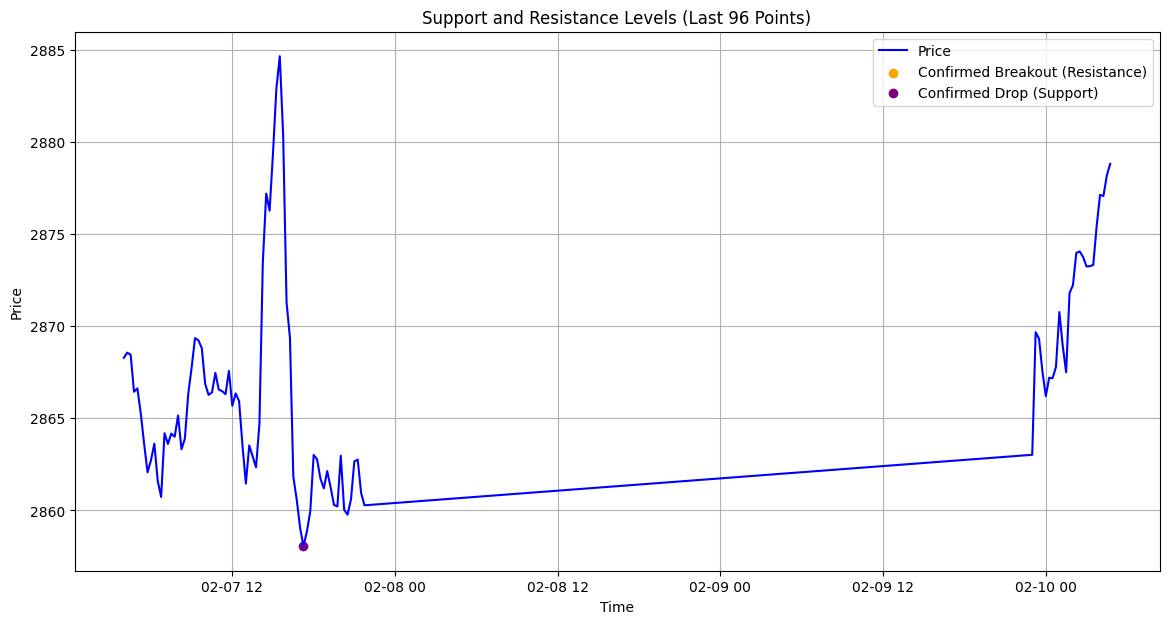

{'support_levels': [(Timestamp('2025-02-07 17:15:00'), 2858.06)], 'resistance_levels': []}


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def plot_support_resistance_with_atvv(data, column='close', atvv_column='ATVV', window_size=5, quantile_threshold=0.8, strategy=1, last_n_points=96):
    """
    自动标记并绘制局部高点和低点作为支撑位和阻力位，结合 ATVV 筛选重要的关键位置，
    并可选择只分析最近的 n 个数据点（例如一天内的时间点）。
    
    参数：
    - data: pd.DataFrame，包含时间序列数据，必须包含价格列和 ATVV 列。
    - column: str，价格列的列名，默认为 'close'。
    - atvv_column: str，ATVV 指标的列名，默认为 'ATVV'。
    - window_size: int，滑动窗口大小，用于识别局部高低点，默认为 5。
    - quantile_threshold: float，ATVV 分位数阈值，用于筛选高 ATVV 的关键位置，默认为 0.8（即筛选出高于 80% 分位数的点）。
    - strategy: int，选择策略。1 表示基于高 ATVV 的静态支撑和阻力位；2 表示确认突破的动态策略。
    - last_n_points: int，分析最近的 n 个数据点，默认为 96（一天内的 15 分钟数据）。
    
    返回：
    - dict，包含最新的支撑位和阻力位。
    - 同时函数会直接绘制价格图，并根据策略标记支撑和阻力位。
    """
    # 只分析最近的 n 个数据点
    data = data.tail(last_n_points).reset_index(drop=True)
    prices = data[column].values
    atvv = data[atvv_column].values
    support_levels = []
    resistance_levels = []
    
    if strategy == 1:
        # 策略 1：筛选高 ATVV 的静态支撑和阻力位
        local_maxima = argrelextrema(prices, comparator=np.greater, order=window_size)[0]
        local_minima = argrelextrema(prices, comparator=np.less, order=window_size)[0]
        
        atvv_threshold = np.quantile(atvv, quantile_threshold)
        high_atvv_maxima = [i for i in local_maxima if atvv[i] >= atvv_threshold]
        high_atvv_minima = [i for i in local_minima if atvv[i] >= atvv_threshold]
        
        resistance_levels = [(data['time'].iloc[i], data[column].iloc[i]) for i in high_atvv_maxima]
        support_levels = [(data['time'].iloc[i], data[column].iloc[i]) for i in high_atvv_minima]
        
        # 绘制价格图并标记高 ATVV 的支撑和阻力位
        plt.figure(figsize=(14, 7))
        plt.plot(data['time'], data[column], label='Price', color='blue')
        plt.scatter(data['time'].iloc[high_atvv_maxima], data[column].iloc[high_atvv_maxima], color='red', label='High ATVV Resistance')
        plt.scatter(data['time'].iloc[high_atvv_minima], data[column].iloc[high_atvv_minima], color='green', label='High ATVV Support')
        
    elif strategy == 2:
        # 策略 2：确认突破时的动态 ATVV 增长
        local_maxima = argrelextrema(prices, comparator=np.greater, order=window_size)[0]
        local_minima = argrelextrema(prices, comparator=np.less, order=window_size)[0]
        
        significant_breakouts = []
        significant_drops = []
        for i in range(1, len(local_maxima)):
            if atvv[local_maxima[i]] > atvv[local_maxima[i-1]] * 1.5:  # ATVV 增长 50% 以上，确认突破
                significant_breakouts.append(local_maxima[i])
        for i in range(1, len(local_minima)):
            if atvv[local_minima[i]] > atvv[local_minima[i-1]] * 1.5:  # ATVV 增长 50% 以上，确认突破
                significant_drops.append(local_minima[i])
        
        resistance_levels = [(data['time'].iloc[i], data[column].iloc[i]) for i in significant_breakouts]
        support_levels = [(data['time'].iloc[i], data[column].iloc[i]) for i in significant_drops]
        
        # 绘制价格图并标记突破确认的阻力和支撑位
        plt.figure(figsize=(14, 7))
        plt.plot(data['time'], data[column], label='Price', color='blue')
        plt.scatter(data['time'].iloc[significant_breakouts], data[column].iloc[significant_breakouts], color='orange', label='Confirmed Breakout (Resistance)')
        plt.scatter(data['time'].iloc[significant_drops], data[column].iloc[significant_drops], color='purple', label='Confirmed Drop (Support)')
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Support and Resistance Levels (Last {} Points)'.format(last_n_points))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'support_levels': support_levels,
        'resistance_levels': resistance_levels
    }

# 示例用法
result = plot_support_resistance_with_atvv(m15, column='close', atvv_column='ATVV', window_size=5, quantile_threshold=0.8, strategy=2, last_n_points=96)
print(result)
